# CHySwash Methodology (II)

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1" 
import os.path as op
from bluemath_tk.datamining.mda import MDA
import xarray as xr
import numpy as np
import inspect
from bluemath_tk.wrappers.swash.swash_wrapper import SwashModelWrapper
import utils.ChySwash
import utils.plotting
import matplotlib.pyplot as plt



fixed_parameters = {
    "dxinp": 1.5,         # bathymetry grid spacing
    "default_Cf": 0.002,  # Friction manning coefficient (m^-1/3 s)
    "Cf_ini": 700 / 1.5,  # Friction start cell
    "Cf_fin": 1250 / 1.5, # Friction end cell
    "comptime": 7200,     # Simulation duration (s)
    "warmup": 7200*0.15,  # Warmup duration (s)
    "n_nodes_per_wavelength": 60 # number of nodes per wavelength
}

# limit maximum Xp to avoid noise close to the beach
X_max = 1750
variance = 0.998
export_dir = "/home/grupos/geocean/valvanuz/HySwash/exported"
data_dir = "/home/grupos/geocean/valvanuz/HySwash/data"
# Define the output directory
output_dir = "/lustre/geocean/DATA/hidronas1/Chy_cases" # CHANGE THIS TO YOUR DESIRED OUTPUT DIRECTORY!
# Templates directory
swash_file_path = op.dirname(inspect.getfile(SwashModelWrapper))
templates_dir = op.join(swash_file_path, "templates")
depth_array=np.loadtxt(op.join(templates_dir, "depth.bot"))

# Load the model
mda=MDA(num_centers=800)
mda=mda.load_model(model_path=op.join(export_dir, "mda_model.pkl"))
mda.plot_selected_centroids()
df_centroids=mda.centroids
postprocessed=xr.open_dataset(op.join(export_dir, "output_postprocessed.nc"))
df_post=postprocessed.sel(Xp=slice(0, X_max))

## Reconstruction: Principal Component Analysis (PCA) & Radial Basis Functions (RBF)

The reconstruction of the time series of wave parameters in the position of the buoy is carried out by an interpolation technique based on radial basis functions (RBF), a scheme wich is very convenient for scatter and multivariate data. The RBF approximation has been applied successfully in many fields, usually with better results than other interpolation methods (Hardy, 1990).
    
Suppose that $f=f(x)$ is the real-valued function that we want to approximate. We are given M scattered data points $\{x_1,..., x_M\}$ of dimension $\textit{n}$ and the associated real function values $\{f_1, ..., f_M\}$, being $f_i = f(x_j), j = 1,...,M$. The RBF interpolation method consists of a weighted sum of radially symmetric basic functions located at the data points. The approximation function is assumed to be of the form:
$$RBF(x) = p(x) + \sum\limits_{j=1}^M a_j\Phi{\large (}{\large \parallel}{x - x_j}{\large \parallel}{\large )}$$

Apply PCA to the postprocessed output

In [ ]:
from bluemath_tk.datamining.pca import PCA

# Apply PCA to the postprocessed output
pca={}
for variable in ["Msetup", "Hrms", "ig"]:    
    pca[variable] = PCA(n_components=variance)
    _pcs_ds = pca[variable].fit_transform(
        data=df_post,
        vars_to_stack=[variable],
        coords_to_stack=["Xp"],
        pca_dim_for_rows="case_num",
        value_to_replace_nans={"Hs": 0.0},
    )
    pca[variable].save_model(model_path=op.join(export_dir, f"pca_{variable}.pkl"))

Apply RBF reconstruction

In [ ]:
# Apply RBF reconstruction
from bluemath_tk.interpolation.rbf import RBF
rbf={}
for variable in ["Msetup", "Hrms", "ig"]: 
    rbf[variable] = RBF()
    rbf[variable].fit(
        subset_data=df_centroids.iloc[df_post["case_num"].values, :],
        target_data=pca[variable].pcs_df,    
    )
    rbf[variable].save_model(
        model_path=op.join(export_dir, f"rbf_{variable}.pkl"),
    )

Plot differences between numerical and analytical results (first 10 cases). Use df_cases to select different cases.

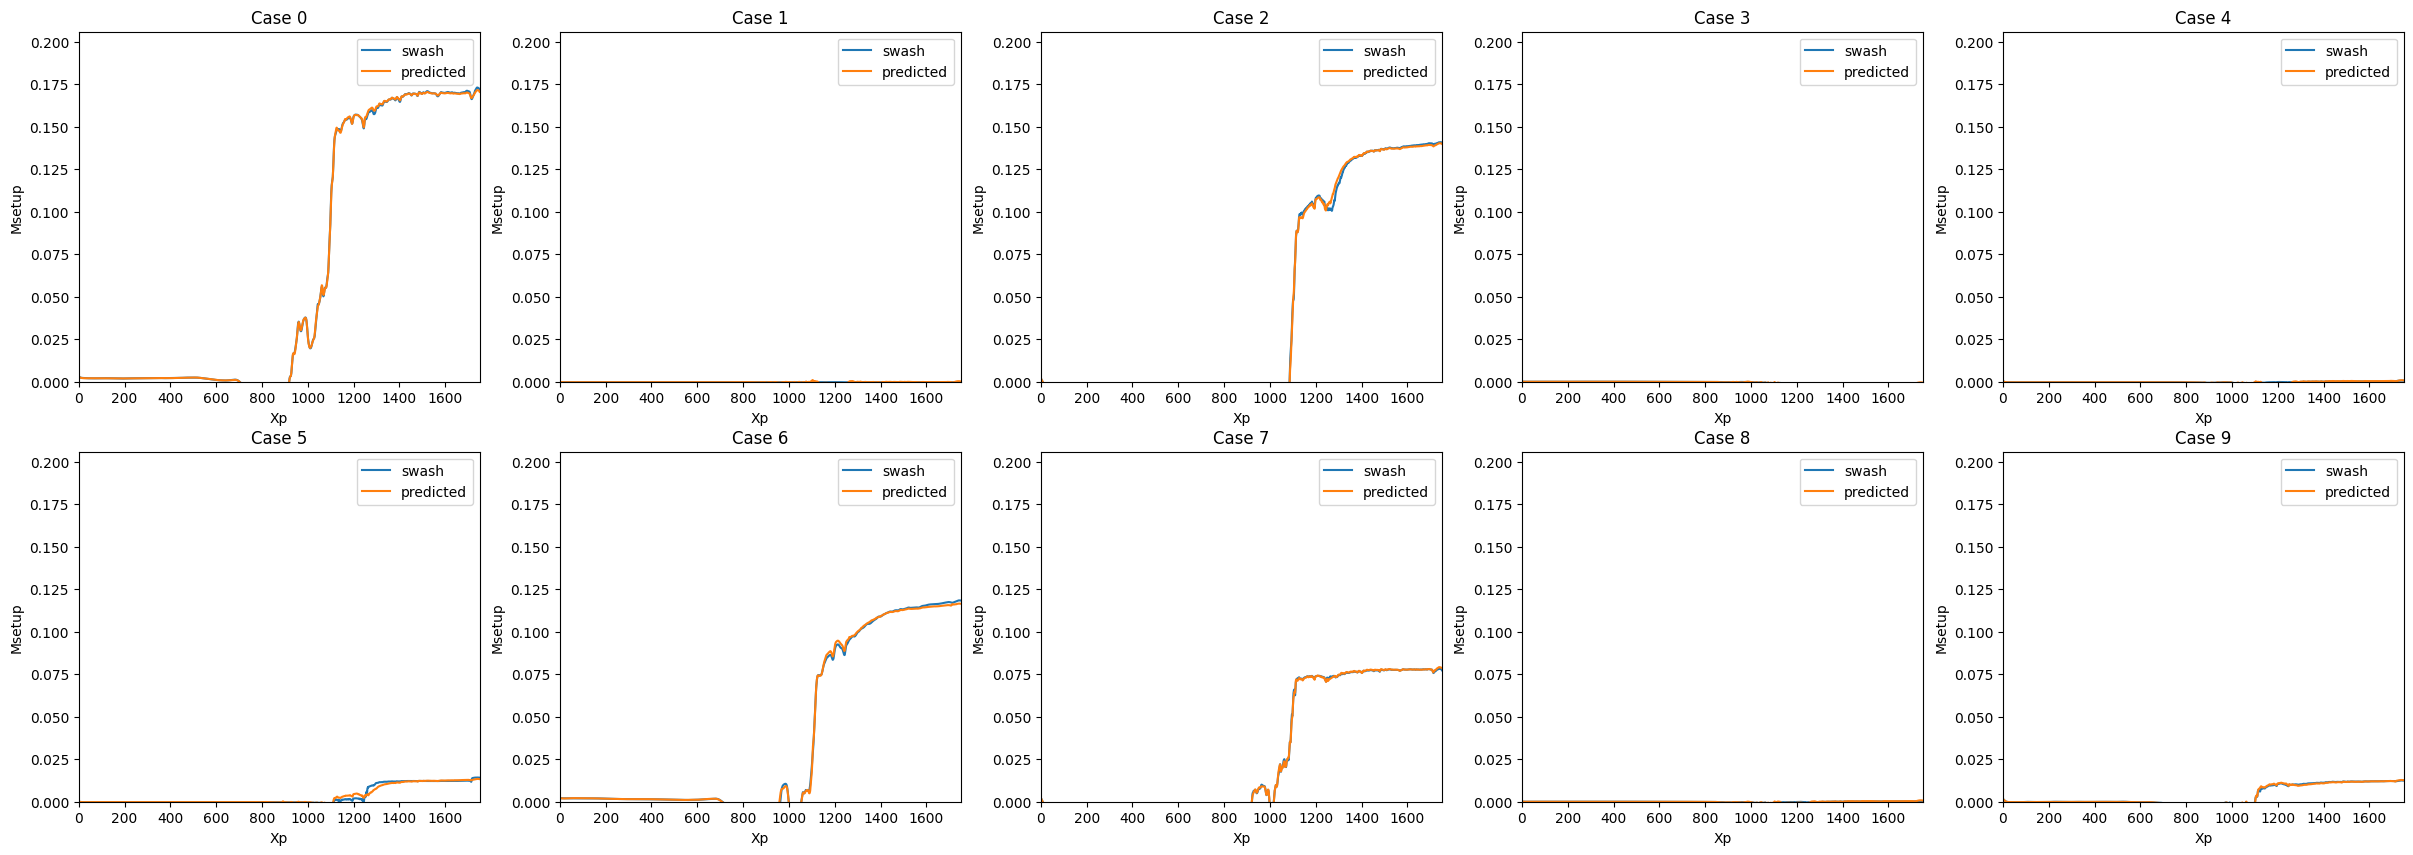

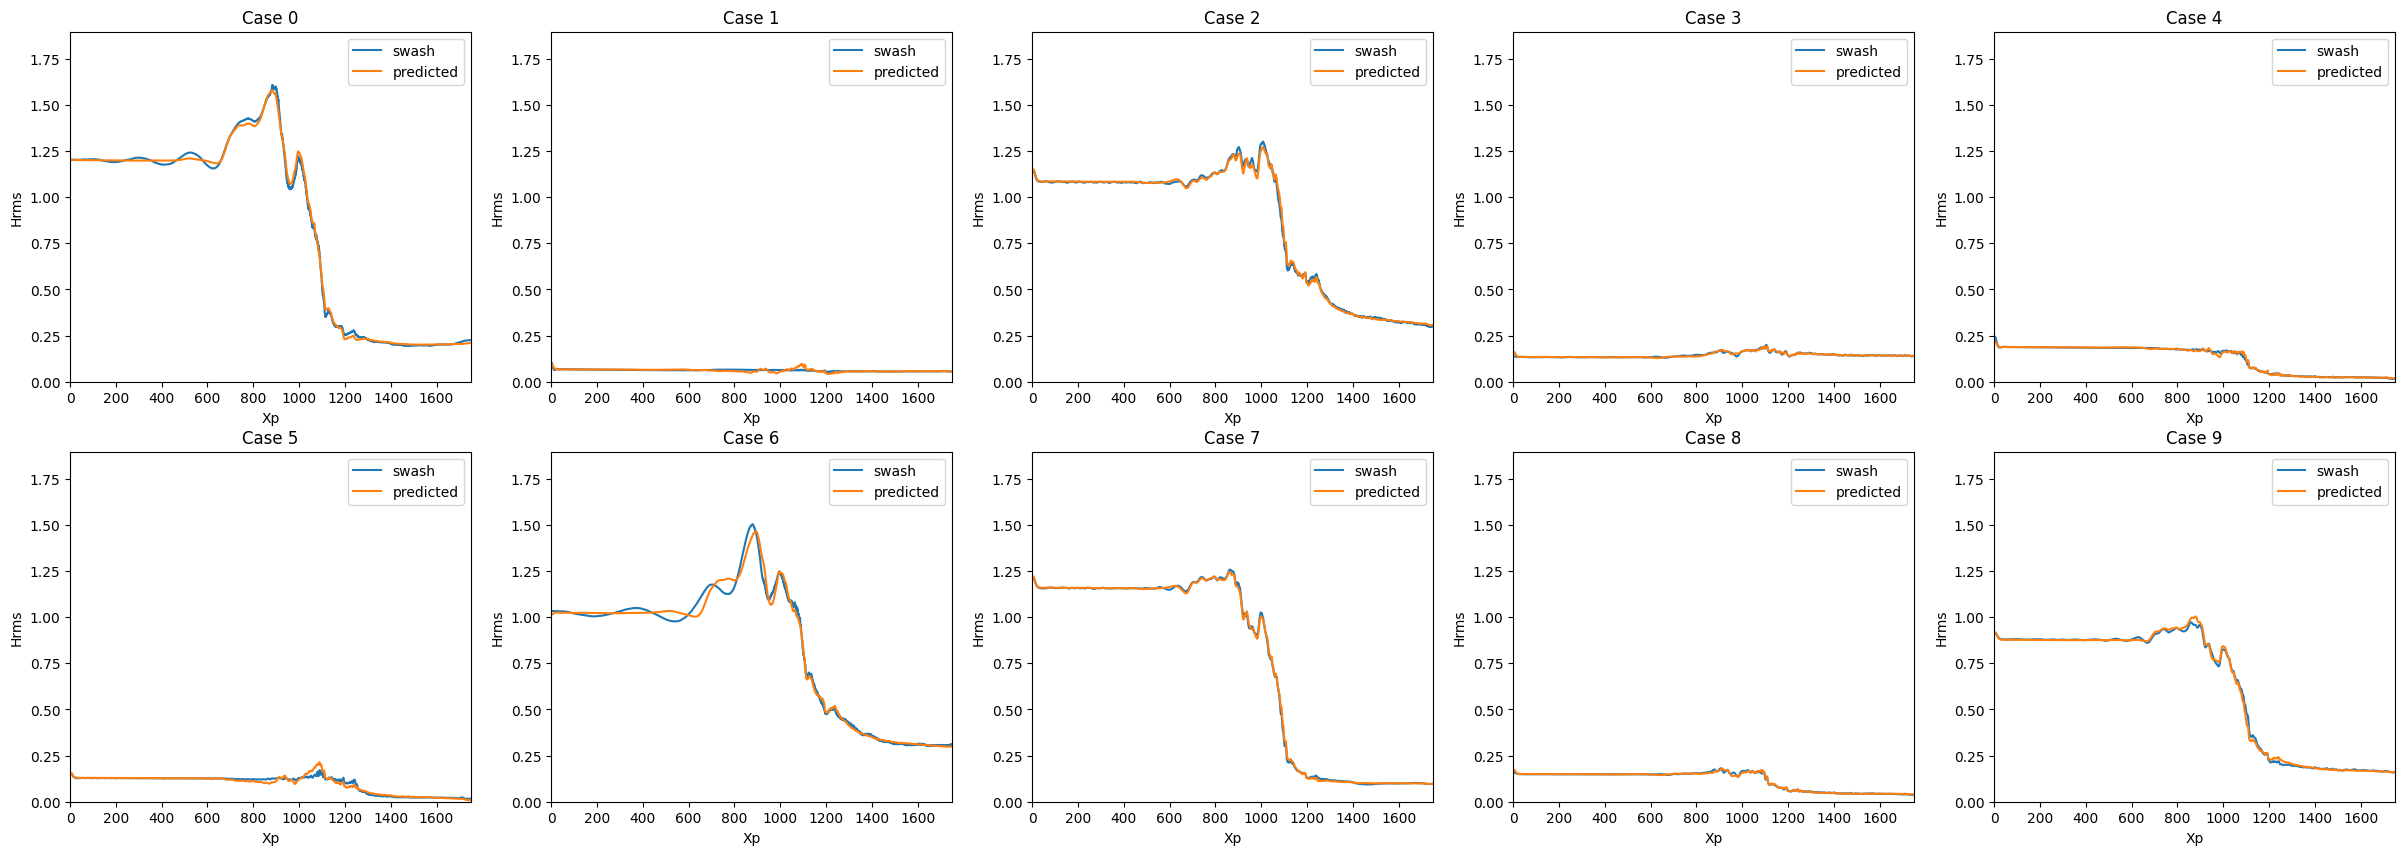

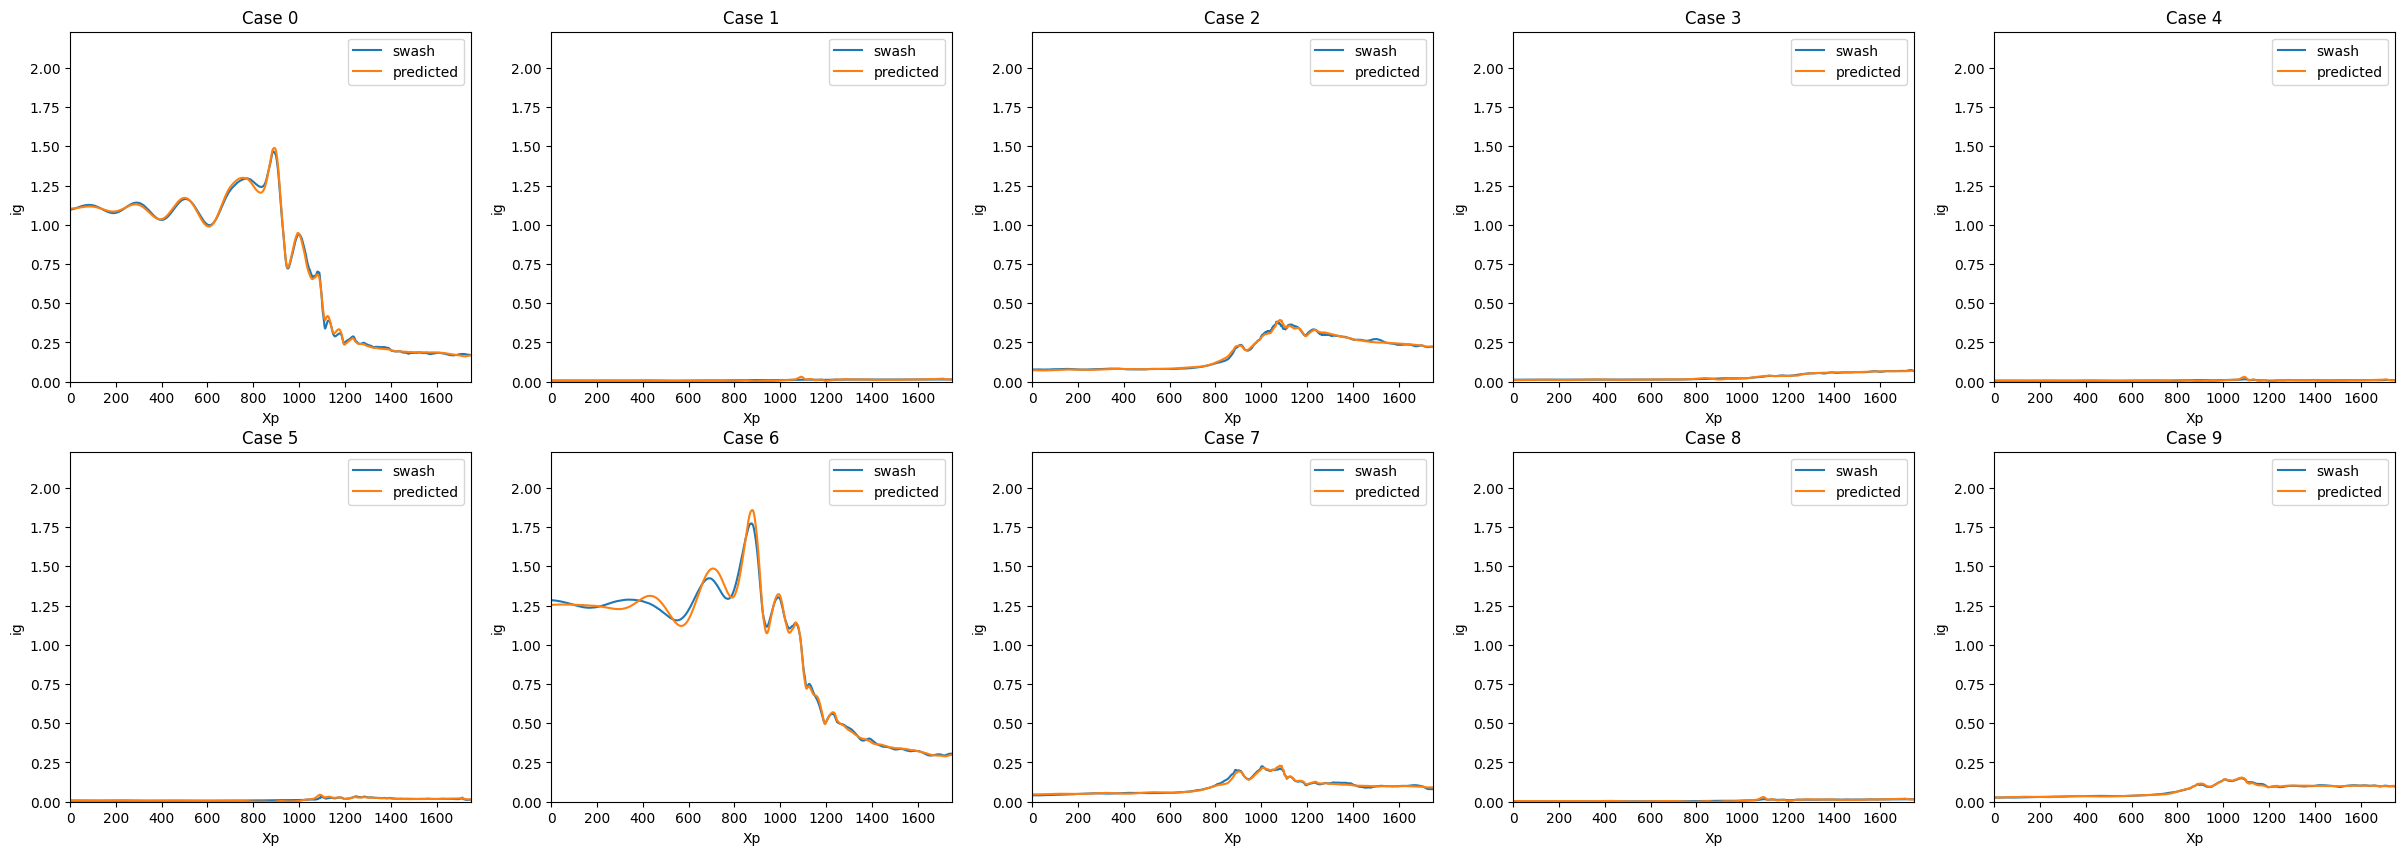

In [31]:
df_cases=df_centroids[0:10]
for variable in ["Msetup", "Hrms", "ig"]:
    ds_output = utils.ChySwash.rbf_pca_predict(df_cases,pca[variable],rbf[variable])
    fig, axes=plt.subplots(2,5,figsize=(30,10))
    ymax=ds_output[variable].values.max()*1.2
    for i in np.arange(0,10):
        postprocessed.sel(case_num=i)[variable].plot(xlim=(0, X_max),ylim=(0,ymax),ax=axes[i//5,i%5],label="swash")
        ds_output.sel(case_num=i)[variable].plot(xlim=(0, X_max),ax=axes[i//5,i%5],label="predicted")
        axes[i//5,i%5].set_title(f"Case {i}")
        axes[i//5,i%5].legend()

Once PCA and RBF fit have been executed load PCA and RBF objects from pickle to avoid fit them again

In [ ]:
from bluemath_tk.datamining.pca import PCA
from bluemath_tk.interpolation.rbf import RBF
#for variable in ["Msetup", "Hrms", "ig"]:

rbf={}
pca={}
for variable in ["Msetup", "Hrms", "ig"]:
    pca[variable] = PCA()
    pca[variable]=pca[variable].load_model(
        model_path=op.join(export_dir, f"pca_{variable}.pkl"),
    )
    rbf[variable] = RBF()
    rbf[variable]=rbf[variable].load_model(
        model_path=op.join(export_dir, f"rbf_{variable}.pkl"),
    )

Once we have access to the interpolation surface, which allows us to obtain the spatial evolution of the output variables Hrms and HsIG for any combination of the 5 input parameters (Hs, Hs/Lo, WL, Cf, and Cr), our next step is to **reconstruct the sea states measured by the sensors using this interpolation function**.

### Sensor C01 measurements
The offshore sensor C01 has recorded a total of 2064 hours, during which values for Hs, WL, Tp and numerous other variables were obtained. Our approach involves constructing a dataset comprising these 2064 sea states measured by the offshore sensor. **These sea states will be input into the interpolation function along with different combinations of Cf and Cr to obtain the evolution of Hrms and HsIG along the profile**. Afterwards, the reconstructed evolution using RBF interpolation will be compared with the actual evolution measured by the sensors to determine the optimal combination of Cf and Cr. The goal is to identify the combination that minimizes the error metric that will be presented next, ensuring that the modeled evolution of both, Hrms and HsIG, closely matches the observed data.

In [21]:
import pandas as pd
# Load data from sensors
df_real={}
df_sensors = pd.read_csv(f"{data_dir}/df_dataset.txt", sep='\t')
sensors_data = pd.read_csv(f"{data_dir}/sensores_data_UTM.txt")
df_real['Hrms'] = pd.read_excel(f"{data_dir}/hrms_by_sensor.xlsx")
df_real['ig'] = pd.read_excel(f"{data_dir}/hsIG_by_sensor.xlsx")
df_real['Msetup'] = pd.read_excel(f"{data_dir}/setup_by_sensor.xlsx")
df_ig_real = pd.read_excel(f"{data_dir}/hsIG_by_sensor.xlsx")

# Create an array with the sensors positions
# Add 500 m to the distance to match the model
sensors_data['Distance'] += 500
sensor_names = sensors_data['Sensor'].values
sensors_positions = sensors_data['Distance'].values

Predict Msetup, Hrms and ig with different Cr and Cf combinations

In [ ]:
for variable in ["Msetup", "Hrms", "ig"]:
#for variable in ["ig"]:
    datasets = []
    #                  (upper, lower, step)
    for Cf in np.arange(0.1, 0.2+0.001, 0.005): 
        for Cr in np.arange(0.4, 0.8+0.01, 0.05): 
            CrCf_nc=f"{data_dir}/CrCf/{variable}_{Cr:.4f}_{Cf:.4f}.nc"
            #If CrCf file already exists, skip the iteration
            if not os.path.exists(CrCf_nc):                                
                df_CrCf = df_sensors.copy()    
                df_CrCf['Cf'] = Cf
                df_CrCf['Cr'] = Cr
                ds_output = utils.ChySwash.rbf_pca_predict(variable,df_CrCf,pca,rbf)
                dataset=ds_output.expand_dims({"Cr": [Cr], "Cf": [Cf]})
                dataset.to_netcdf(CrCf_nc)
            else:
                print(f"File {CrCf_nc} already exists, skipping iteration")

Load files with Msetup and Hrms predictions for each sea state observation (2065) and all the combinatios of Cf and Cr coefficients

In [22]:
predicted_sea_states={}
for variable in ["Msetup", "Hrms","ig"]:
    predicted_sea_states[variable] = xr.open_mfdataset(f"{data_dir}/CrCf/{variable}_*.nc")

Plot error in prediction Msetup, Hrms and ig for each Cr Cf combination

In [23]:
df_error_prediction={}
sum_total=0
for variable in ["Hrms", "Msetup","ig"]:
    error_prediction=[]
    df_var=predicted_sea_states[variable]
    sum2=0
    CfCrError=[]
    for Cr in df_var.Cr.values:
        for Cf in df_var.Cf.values:
        # Load the data from the sensors
            # Interpolate the data to the sensor positions            
            np_sensors_predicted = df_var.sel(Cf=Cf,Cr=Cr,Xp=sensors_positions, method='nearest')[variable].values
            df_sensors_predicted = pd.DataFrame(np_sensors_predicted)
            df_sensors_predicted.columns = sensor_names
            # (y_predicted - y_real)^2 
            diff_pred_real=(df_sensors_predicted-df_real[variable])**2
            # sum agregated by sea state / number of measurements
            sum_error_columns=np.sqrt(diff_pred_real.sum()/diff_pred_real.notna().sum())
            total_error=sum_error_columns.mean()
            #if Cf<0.10005 and Cr<0.4000001:
                #print(f"Cr: {Cr} Cf: {Cf} predicted: {diff_pred_real} {diff_pred_real.notna().sum()}")
            CfCrError.append({"Cf": Cf, "Cr": Cr, "error": total_error})
            #print(f'Error calculation done for {archivo}')

    df_error_prediction[variable] = pd.DataFrame(CfCrError)


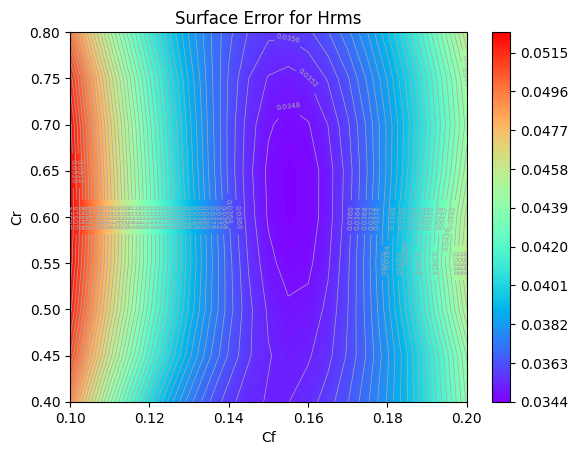

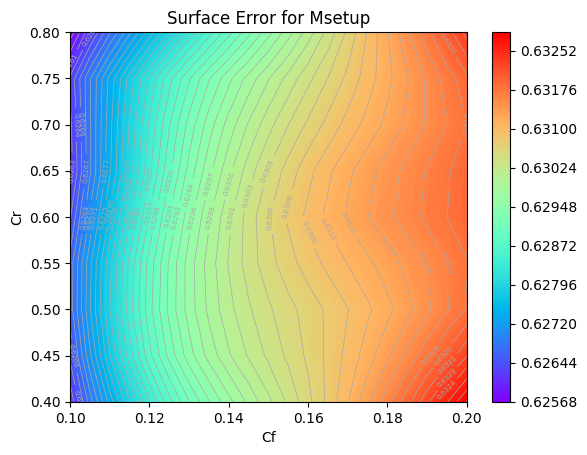

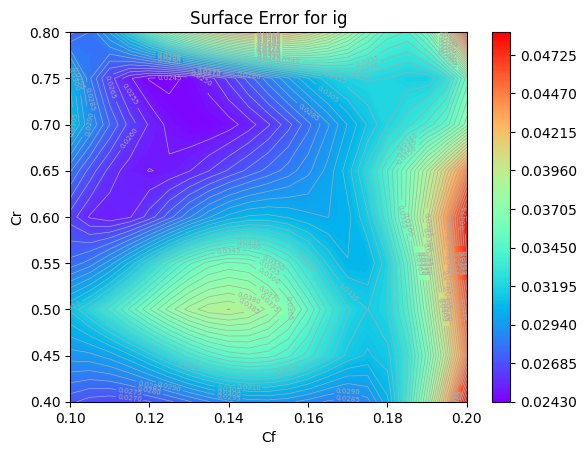

In [24]:
import matplotlib.pyplot as plt

for variable in ["Hrms", "Msetup","ig"]:
    df_errors=df_error_prediction[variable]
    pivot_table = df_errors.pivot(index='Cr', columns='Cf', values='error')

    # Get the grid values for Cf, Cr, and error
    Cf_values = pivot_table.columns.values
    Cr_values = pivot_table.index.values
    error_values = pivot_table.values

    # Plotting
    contourf = plt.contourf(Cf_values, Cr_values, error_values, levels=200, cmap='rainbow', vmin=None, vmax=None)
    contour_lines = plt.contour(Cf_values, Cr_values, error_values, levels=50 , colors='darkgrey', linewidths=0.5)
    plt.clabel(contour_lines, inline=True, fontsize=5, fmt='%.4f')
    plt.colorbar(contourf)
    plt.title(f'Surface Error for {variable}')
    plt.xlabel('Cf')
    plt.ylabel('Cr')
    plt.show()

Finally, to obtain the final total error for a single combination of coefficientes, we add both errors :

$$Total Error = Error_{hrms} + Error_{hsIG}$$

In [25]:
df_agg_error=(df_error_prediction["Hrms"] + df_error_prediction["ig"]).sort_index()
df_agg_error

,Cf,Cr,error
0,0.20,0.8,0.076332
1,0.21,0.8,0.073317
2,0.22,0.8,0.070776
3,0.23,0.8,0.068729
4,0.24,0.8,0.067166
...,...,...,...
184,0.36,1.6,0.073507
185,0.37,1.6,0.074459
186,0.38,1.6,0.077609
187,0.39,1.6,0.083587


## Automatic Calibration : SCE Optimization Algorithm
- SCE_algorithm.py: Algorithm developed by Q.Duan, 9/2004 and converted to python from by Van Hoey S.2011 (https://github.com/stijnvanhoey/Optimization_SCE)

In [ ]:
# import SCE algorithm
from utils.SCE_algorithm import sceua
#from utils.SCE_functioncall import *

# Parámetros del modelo SCE-UA:
# Se puede concultar su significado en SCE_algorithm.py

iseed   = 0
iniflg  = 0 # Con iniflg=0, los valores iniciales de Cf y Cr se generarán aleatoriamente dentro de los límites 
            # bl y bu especificados, proporcionando una diversidad de soluciones iniciales.
ngs     = 5 # Con ngs=5, la población de soluciones iniciales se dividirá en 5 subgrupos. 
            # Cada subgrupo buscará minimizar el error RMSE de manera independiente, lo que aumenta la probabilidad 
            # de encontrar el mínimo global del error.
peps    = 0.001 # Define el criterio de parada basado en la mejora relativa de la función objetivo. Si la mejora 
                # en la función objetivo (error RMSE) es menor que peps, el algoritmo considera que ha convergido. 
                # El algoritmo considerará que ha convergido si la mejora en el error RMSE es menor al 0.1% entre 
                # iteraciones consecutivas.
maxn    = 100 # Establece el límite en el número de evaluaciones de la función objetivo que se pueden realizar. 
                # Una vez alcanzado este límite, el algoritmo se detendrá, incluso si no ha convergido.
kstop   = 10 # Define el número máximo de ciclos de evolución sin mejora significativa antes de que se considere que el 
             # algoritmo ha convergido. Con kstop=30, si no se observa una mejora significativa en el error RMSE 
             # después de 30 ciclos de evolución, el algoritmo se detendrá, asumiendo que ha alcanzado la convergencia.
pcento  = 0.01 # Especifica el cambio porcentual permitido en la función objetivo durante kstop ciclos de evolución 
                # antes de que se considere que el algoritmo ha convergido. Con pcento=0.001, el algoritmo considerará 
                # que ha convergido si el cambio porcentual en el error RMSE es menor que 0.1% durante 30 ciclos consecutivos. 
                # Esto asegura que el error RMSE se ha estabilizado antes de que el algoritmo se detenga.
# Define bounds and x0
def rbf_prediction_error(x, data=None):
    print(x[0])
    print(x[1])
    print(f"Evaluating {x[0]:.4f} {x[1]:.4f}")
    
    error=0
    for variable in ["Hrms", "ig"]:   
                            
        df_CrCf = df_sensors.copy()    
        df_CrCf['Cf'] = x[0]
        df_CrCf['Cr'] = x[1]
        # Spatial Reconstruction
        df_var = utils.ChySwash.rbf_pca_predict(df_CrCf,pca[variable],rbf[variable])

        # Load the data from the sensors
        # Interpolate the data to the sensor positions            
        np_sensors_predicted = df_var.sel(Xp=sensors_positions, method='nearest')[variable].values
        df_sensors_predicted = pd.DataFrame(np_sensors_predicted)
        df_sensors_predicted.columns = sensor_names
        # (y_predicted - y_real)^2 
        diff_pred_real=(df_sensors_predicted-df_real[variable])**2
        # sum agregated by sea state / number of measurements
        sum_error_columns=np.sqrt(diff_pred_real.sum()/diff_pred_real.notna().sum())
        error=error + sum_error_columns.mean()
    return error



bl = np.array([0.10, 0.40]) # lower bound
bu = np.array([0.20, 0.80]) # upper bound
x0 = np.array([0.1001, 0.4001])

# Optimal Parameters
bestx, bestf, BESTX, BESTF, ICALL = sceua(x0, bl, bu, maxn, kstop, pcento, peps, ngs, iseed, iniflg, function_opt = rbf_prediction_error)

After running optimization, the best values of Cf and Cr are: array([0.14465558, 0.71805765])

## Spatial evolution of the variable along the profile
### Hrms: Reconstruct for bestx
Here, we choose reconstruct case_num 330 but any other case_num can be chosen


2025-04-15 14:02:38,130 - RBF - WARNING - Proposed min custom scaler for Hs_L0 is bigger than datapoint
2025-04-15 14:02:38,130 - RBF - WARNING - Proposed min custom scaler for WL is bigger than datapoint
2025-04-15 14:02:38,131 - RBF - WARNING - Proposed max custom scaler for WL is lower than datapoint
/tmp/ipykernel_2958104/1120252262.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_values = df_hrms.loc[case_num][i]
2025-04-15 14:02:38,744 - RBF - WARNING - Proposed min custom scaler for Hs_L0 is bigger than datapoint
2025-04-15 14:02:38,745 - RBF - WARNING - Proposed min custom scaler for WL is bigger than datapoint
2025-04-15 14:02:38,745 - RBF - WARNING - Proposed max custom scaler for WL is lower than datapoint
/tmp/ipykernel_2958104/1120252262.py:15: FutureWarning: Series.__getitem__ trea

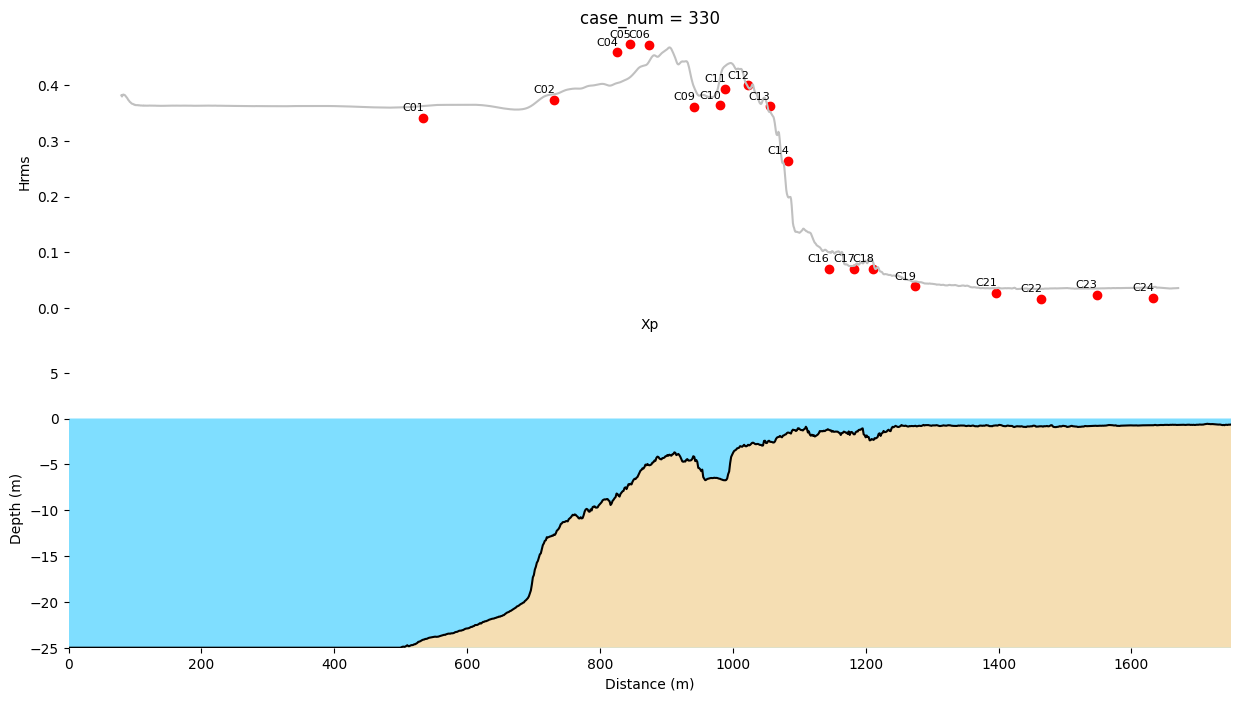

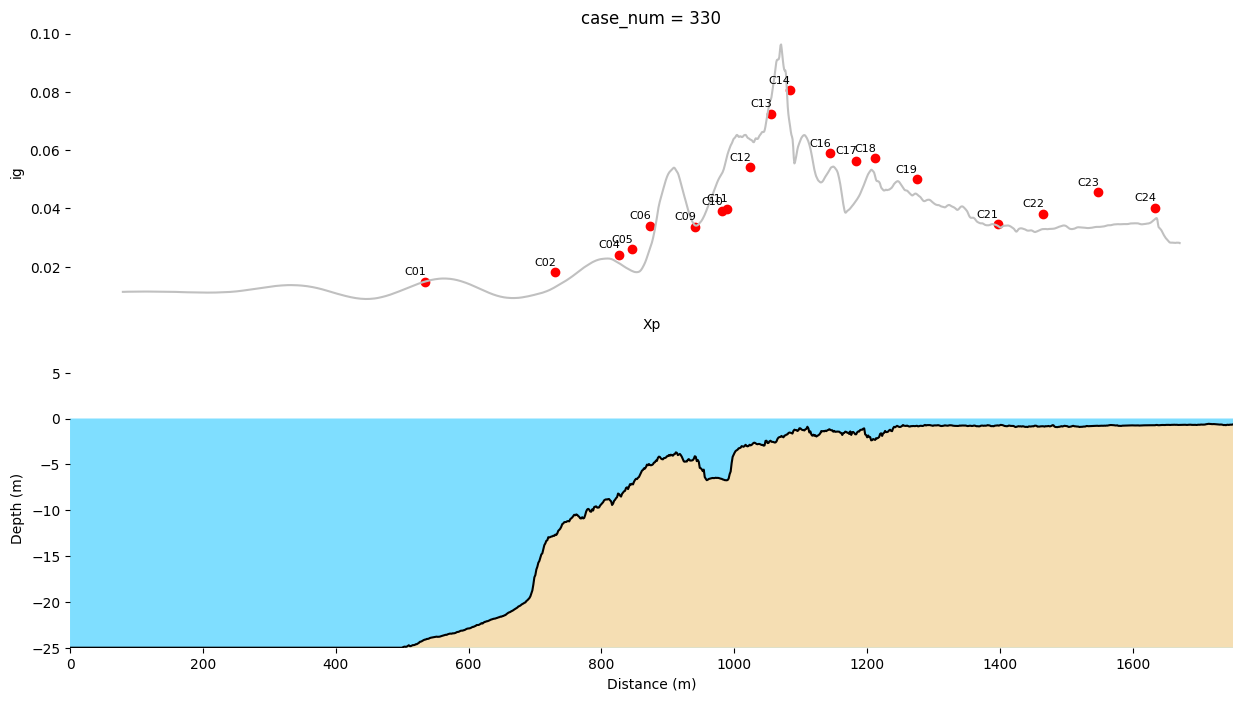

In [30]:


case_num=330
df_opt_CrCf = df_sensors.copy()    
df_opt_CrCf['Cf'] = 0.14465558
df_opt_CrCf['Cr'] = 0.71805765

for variable in ["Hrms", "ig"]:
    # Spatial Reconstruction
    df_var = utils.ChySwash.rbf_pca_predict(df_opt_CrCf,pca[variable],rbf[variable])
    df_hrms=df_real[variable]
    fig, axes = plt.subplots(2, 1,figsize=(15, 8))
    df_var[variable].sel(case_num=case_num).plot(ax=axes[0], label="predicted",color='silver')
    axes[0].scatter(sensors_positions, df_hrms.loc[case_num], color='red', label="buoys")
    for i, sensor in enumerate(sensor_names):
        x_values = sensors_positions[i]
        y_values = df_hrms.loc[case_num][i]
        axes[0].annotate(sensor, (x_values, y_values),textcoords='offset points', color='black', fontsize=8, xytext=(-15, 5))
    # Remove every border from axes[0]
    for border in ['left', 'right', 'bottom', 'top']:
        axes[0].spines[border].set_visible(False)
    axes[0].set_xticks([]) 
        
    utils.plotting.plot_depthfile(depthfile=op.join(templates_dir, "depth.bot"), ax=axes[1], xlim=(0, X_max), dxinp=fixed_parameters["dxinp"])
